# Physics-Informed Neural Networks (PINNs) Workshop
# HiAi 25-27.5.2025
## Solving the 1D Heat Equation using PINNs

In [1]:
#!pip install torch matplotlib numpy pandas

### imports and installations

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set seed for reproducibility
torch.manual_seed(42)

## Configure 1D heat equation system parameters
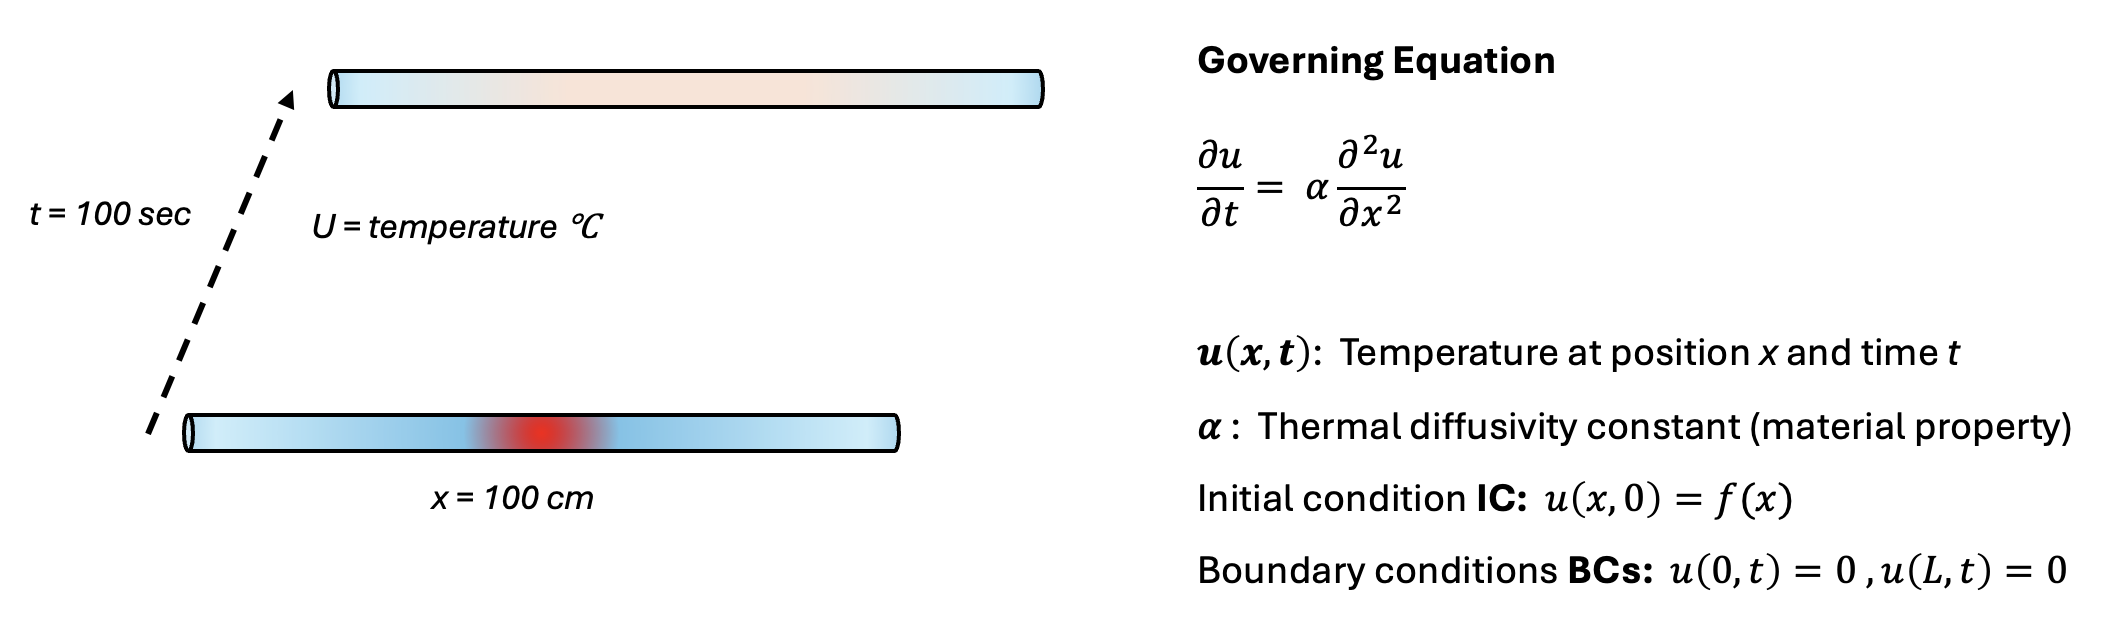

#### System Parameters

In [3]:
alpha = 0.1       # original thermal diffusivity [m^2/s]
L     = 100       # domain length [m]
T_max = 100     # max time [s]
U_max = 100    # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

### Set up initial conditions configuration
##### Consider 2 optional IC setups- sinusoidal and block heat source


In [ ]:
# create a sinusoidal distribution initial condition
def i_c_sin(x_initial):
    u_initial = torch.sin(torch.pi * x_initial)
    return u_initial

# create a block heat source initial condition (temperature distribution between 0 and 1)
def i_c_block(x_initial):
    center1 = 0.35
    center2 = 0.8
    width1 = 0.2
    width2 = 0.35
    # Create mask for points inside the block
    mask1 = (x_initial >= (center1 - width1/2)) & (x_initial <= (center1 + width1/2))
    mask2 = (x_initial >= (center2 - width2/2)) & (x_initial <= (center2 + width2/2))
    # Initialize with low temperature
    u_initial = torch.full_like(x_initial, 0)
    # Set high temperature for points inside the block
    u_initial[mask1] = 1
    u_initial[mask2] = 1

    return u_initial

# generate initial conditions training data
def generate_initial_data(num_boundary_points, system_params, initial_condition = i_c_sin):
    x_initial = torch.rand(num_boundary_points, 1, requires_grad=True) # random x values (0-1) for the initial condition
    t_initial = torch.zeros_like(x_initial) # time is 0 for the initial condition
    u_initial = initial_condition(x_initial) # create the initial temperature distribution
    # scale the initial data to the system parameters
    x_initial = x_initial * system_params['L']
    u_initial = u_initial * system_params['U_max']
    return x_initial, t_initial, u_initial


### Configure Boundry Conditions & Domain Training points

In [ ]:
def generate_boundary_data(num_boundary_points, system_params, boundary_value=0):
    # create x_boundary and t_boundary
    x_boundary_0 = torch.zeros(num_boundary_points, 1, requires_grad=True)  # x = 0 boundary
    x_boundary_1 = torch.ones(num_boundary_points, 1, requires_grad=True) * system_params['L'] # x = L boundary
    x_boundary = torch.cat([x_boundary_0, x_boundary_1], dim=0)   # combine both boundaries

    t_boundary = torch.rand(num_boundary_points * 2, 1, requires_grad=True) * system_params['T_max']  # random time points to match the boudaries

    u_boundary = torch.full_like(x_boundary, boundary_value) # set the boundary values to the boundary points

    return x_boundary, t_boundary, u_boundary

# Generate a random setup of interior domain points to train the model on
def generate_domain_points(num_domain_points, system_params):
    x_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['L']
    t_domain = torch.rand(num_domain_points, 1, requires_grad = True) * system_params['T_max']

    return x_domain,t_domain

### Plot IC and BC

In [ ]:
def plot_IC_BC(num_domain_points=num_domain_points,
                num_boundary_points=num_boundary_points,
                system_params=system_params,
                initial_condition=i_c_sin, plot_IC_alone=True):
    # Generate data
    x_domain, t_domain= generate_domain_points(num_domain_points, system_params)
    x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)
    x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)
    # Convert to numpy arrays
    x_init_np , t_init_np , u_init_np = x_initial.detach().numpy(), t_initial.detach().numpy(), u_initial.detach().numpy()
    x_boundary_np , t_boundary_np , u_boundary_np = x_boundary.detach().numpy(), t_boundary.detach().numpy(), u_boundary.detach().numpy()
    # Unite all x,t,u in one array
    x_np = np.concatenate((x_init_np, x_boundary_np))
    t_np = np.concatenate((t_init_np, t_boundary_np))
    u_np = np.concatenate((u_init_np, u_boundary_np))

    if plot_IC_alone:
        fig = plt.figure(figsize=(8, 4))
        # Scatter plot of u_init_np vs x_init_np
        plt.scatter(x_init_np, u_init_np, c=u_init_np, cmap='coolwarm')
        plt.xlabel('Position x (m)')
        plt.ylabel('Temperature u (°C)')
        plt.title('Initial Condition at time t=0')
        plt.colorbar(label='Temperature')
        plt.show()


    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x_np), np.unique(t_np))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x_np, t_np, np.zeros_like(x_np), c=u_np, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title('Initial Condition and Boundary Condition')
    plt.show()


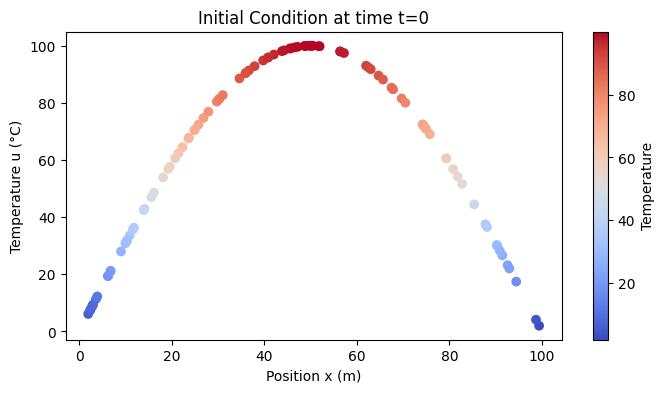

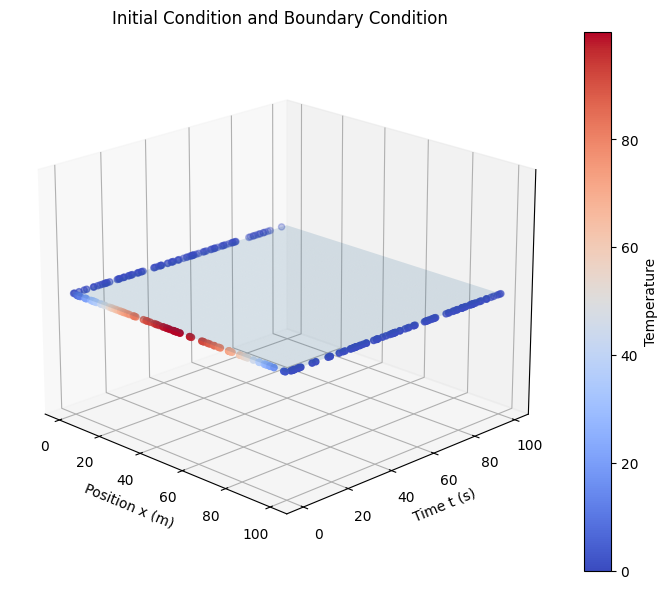

In [ ]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_sin)

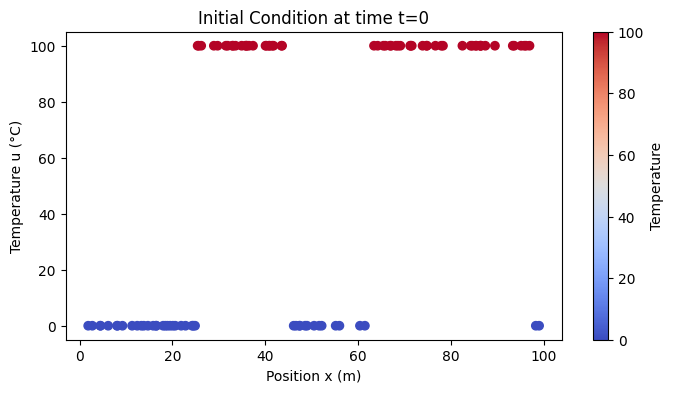

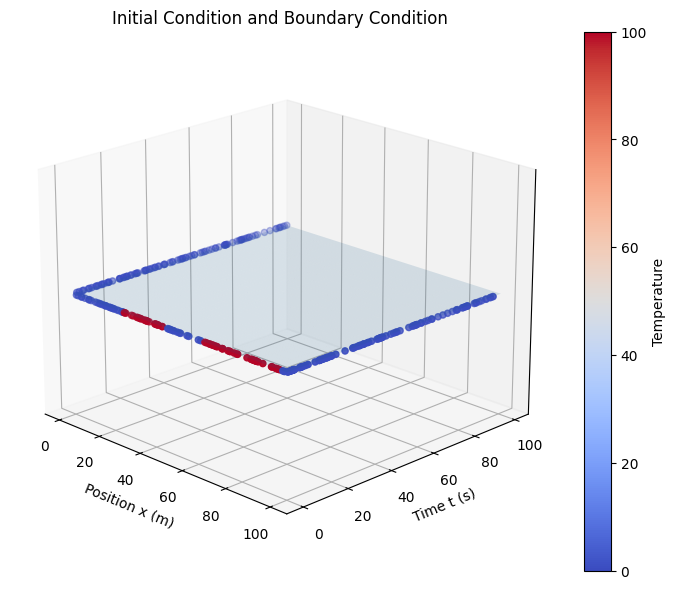

In [ ]:
plot_IC_BC(num_domain_points, num_boundary_points, initial_condition=i_c_block)

## Construct PINN Model

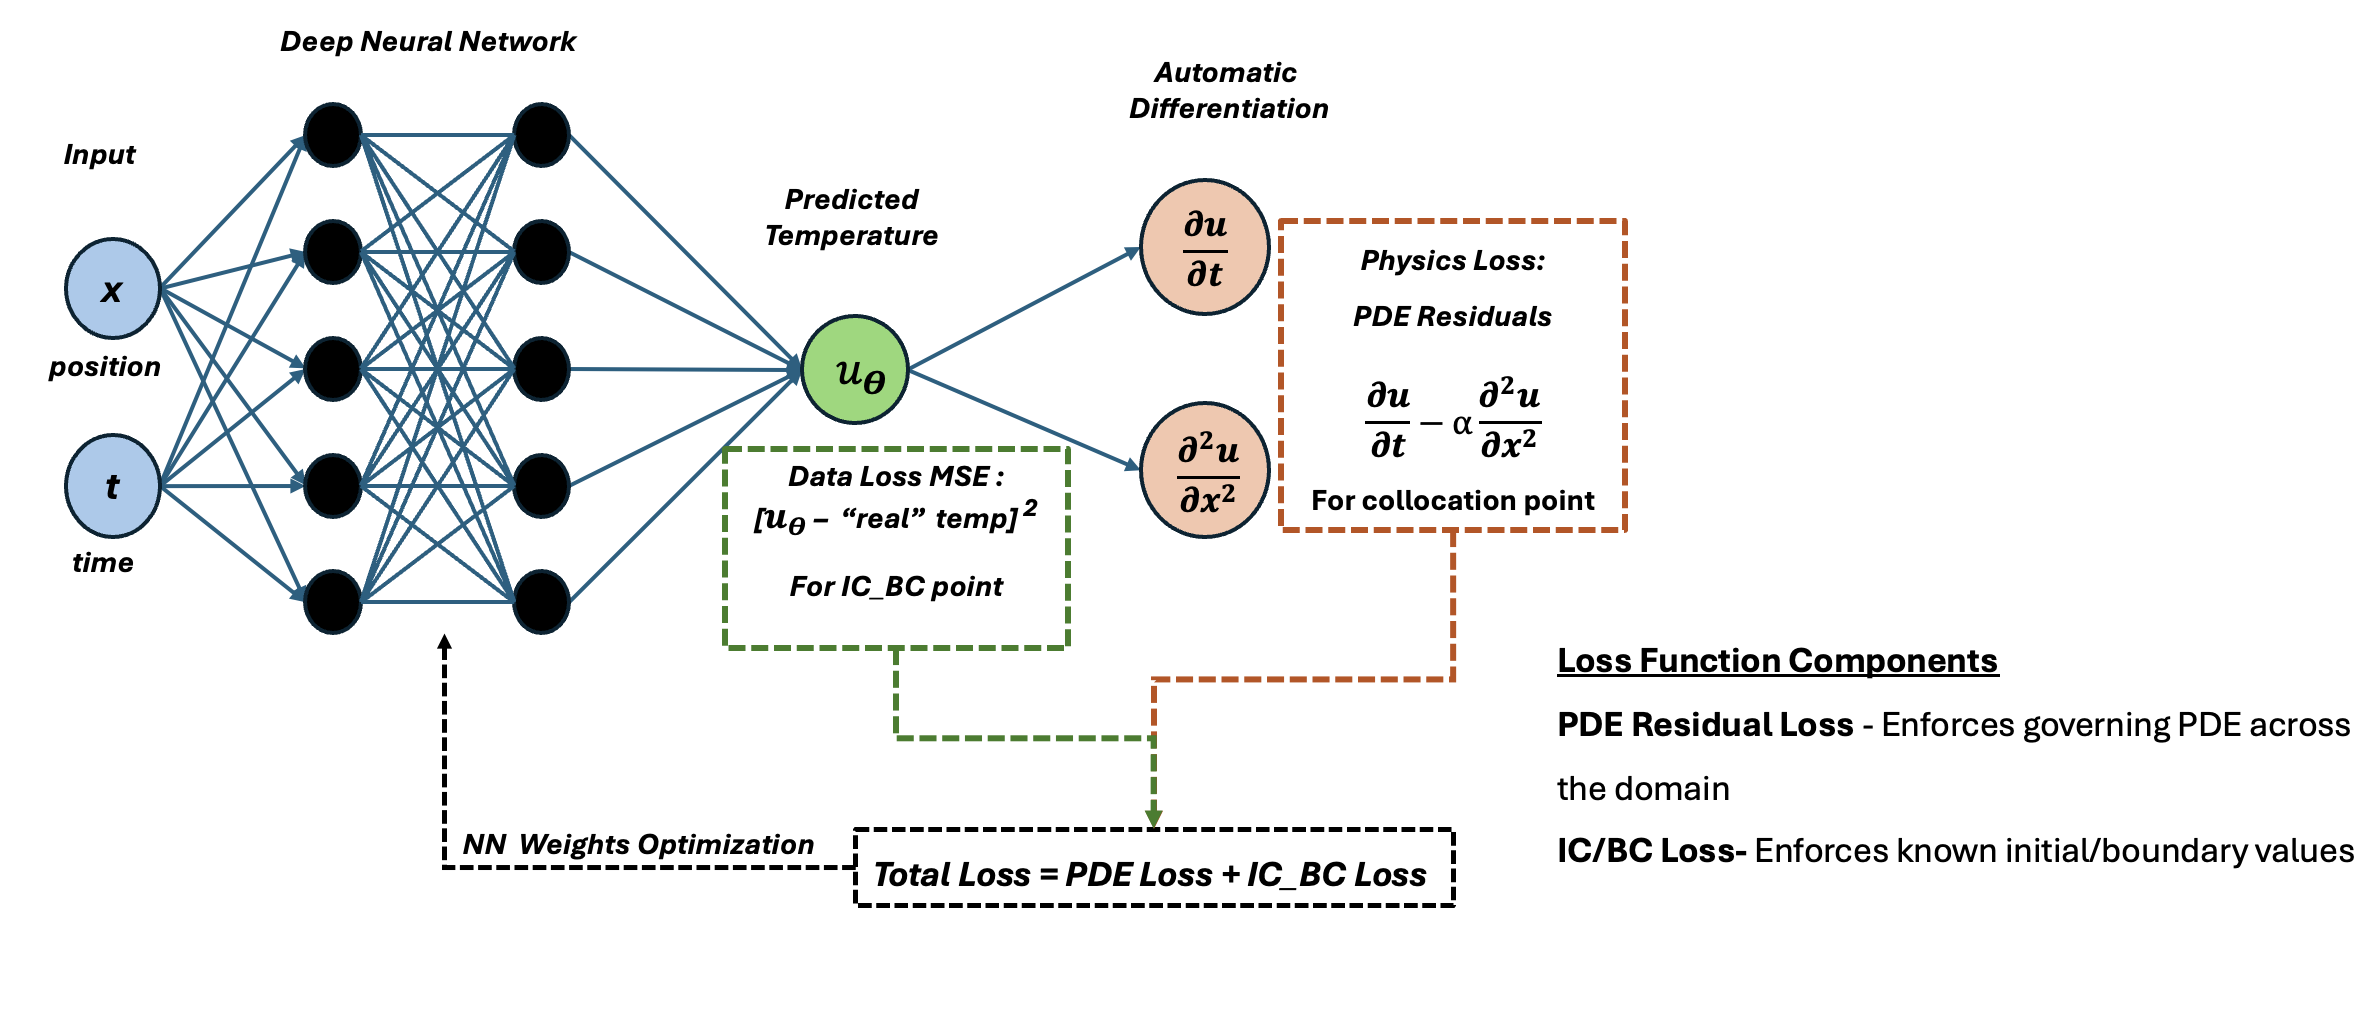

### Neural Network Architechture

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.net(x)

### Define PDE residual loss
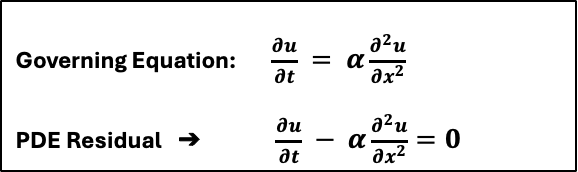![](diff_eq.png)

In [ ]:
def pde(x,t,model,system_params):
    # Concatenate position (x) and time (t) to create the input for the neural network
    input_data = torch.cat([x,t],dim=1)
    # Get the temperature prediction (u) from the model for the given (x,t)
    u = model(input_data)
    # Extract system parameters
    alpha= system_params['alpha']
    T_max = system_params['T_max']
    L = system_params['L']

    # Calculate the normalized thermal diffusivity term for the PDE
    alpha_norm = alpha * T_max / L**2

    # Calculate the first derivative of u with respect to x (du/dx)
    du_dx = torch.autograd.grad(u, x,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]
    # Calculate the second derivative of u with respect to x (d^2u/dx^2)
    d2u_dx2 = torch.autograd.grad(du_dx,x,grad_outputs= torch.ones_like(du_dx), create_graph= True, retain_graph=True)[0]
    # Calculate the first derivative of u with respect to t (du/dt)
    du_dt = torch.autograd.grad(u,t,grad_outputs= torch.ones_like(u), create_graph= True, retain_graph=True)[0]

    # Calculate the residual of the 1D heat equation: du/dt - alpha_norm * d^2u/dx^2
    heat_eq_residual = du_dt - (alpha_norm * d2u_dx2)

    return heat_eq_residual

### Set Training loop

In [ ]:
def train_PINN(model, num_iterations, system_params, num_domain_points, num_boundary_points, initial_condition=i_c_sin,
               loss_weights = {'ic': 1, 'bc': 1, 'pde': 1}, print_loss = True):

    # Initialize Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store loss history
    ic_losses = []
    bc_losses = []
    pde_losses = []
    total_losses = []

    # Loss weights
    w_ic = loss_weights['ic']
    w_bc = loss_weights['bc']
    w_pde = loss_weights['pde']

    # Training loop
    for  iteration in range(num_iterations):
        # Zero gradients
        optimizer.zero_grad()

        # Generate domain points
        x_domain, t_domain= generate_domain_points(num_domain_points, system_params)

        # Generate boundary condition data
        x_boundary, t_boundary, u_boundary = generate_boundary_data(num_boundary_points, system_params, boundary_value=0)

        # Generate initial condition data
        x_initial, t_initial, u_initial = generate_initial_data(num_boundary_points, system_params, initial_condition)

        # Calculate PDE residual
        residual = pde(x_domain,t_domain,model,system_params)

        # Calculate individual losses (MSE)
        ic_loss= nn.MSELoss()(u_initial, model(torch.cat([x_initial, t_initial], dim=1))) * w_ic
        bc_loss = nn.MSELoss()(u_boundary, model(torch.cat([x_boundary, t_boundary], dim=1))) * w_bc
        pde_loss = nn.MSELoss()(residual, torch.zeros_like(residual)) * w_pde

        # Calculate total loss
        loss = ic_loss + bc_loss + pde_loss

        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Record losses
        ic_losses.append(ic_loss.item())
        bc_losses.append(bc_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(loss.item())


        # Print loss periodically
        if iteration % 1000 ==0:
            if print_loss:
                print("iter", iteration, "total_loss", f"{loss.item():.3f}", "ic_loss", f"{ic_loss.item():.4f}", "bc_loss", f"{bc_loss.item():.4f}", "pde_loss", f"{pde_loss.item():.4f}")

    # Create DataFrame from loss history
    df = pd.DataFrame({'ic_loss': ic_losses, 'bc_loss': bc_losses, 'pde_loss': pde_losses, 'total_loss': total_losses})
    return df

## Train model & Evaluate results

#### Ploting functions

In [ ]:
def plot_PINN_results(model, system_params, num_time_steps=10, sample_results = 0):
    x_plot = []
    t_plot = []
    u_pred = []
    with torch.no_grad():
        x_vals = torch.linspace(0,system_params['L'],100)
        for t in range(num_time_steps):
            t_val = torch.ones_like(x_vals) * t/num_time_steps * system_params['T_max']
            input_data = torch.stack([x_vals.flatten(),t_val.flatten()], dim=1)
            solution = model(input_data)
            x_plot.append(x_vals)
            t_plot.append(t_val)
            u_pred.append(solution)

    # Convert to numpy and flatten all arrays
    x_plot = torch.cat(x_plot).numpy()
    t_plot = torch.cat(t_plot).numpy()
    u_pred_np = torch.cat(u_pred).numpy()

    # Plot
    plt.figure(figsize=(8, 7))
    plt.scatter(x_plot, t_plot, c=u_pred_np, cmap='coolwarm')
    plt.clim(0, system_params['U_max'])
    plt.ylim(0, system_params['T_max'])
    plt.xlabel('Position x (m)')
    plt.ylabel('Time t (s)')
    plt.title('PINN Temperature Prediction')
    plt.colorbar(label='Temperature')
    plt.show()

    # create a sample index to select random x,t,u point from the results as the number of sample_results
    if sample_results > 0:
        sample_index = np.random.randint(0, len(x_plot), sample_results)
        x_plot_sample = x_plot[sample_index]
        t_plot_sample = t_plot[sample_index]
        u_pred_sample = u_pred_np[sample_index].flatten()

        # pack to data frame
        sample_results = pd.DataFrame({'x': x_plot_sample, 't': t_plot_sample, 'u': u_pred_sample})

        return sample_results

def plot_losses(df, log_scale=False):
    plt.figure(figsize=(9, 4))
    plt.plot(df['total_loss'], label='Total Loss')
    plt.plot(df['ic_loss'], label='IC Loss')
    plt.plot(df['bc_loss'], label='BC Loss')
    plt.plot(df['pde_loss'], label='PDE Loss')
    # set y axis to log scale
    if log_scale:
        plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Losses over iterations')
    plt.legend()
    plt.show()

def plot_results_2D_tilted(x, t, u, title='Sample measurement'):
    # For a 2D tilted view (alternative approach)
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot with zero height
    x_grid, t_grid = np.meshgrid(np.unique(x), np.unique(t))
    z_grid = np.zeros_like(x_grid)  # Create a flat surface
    ax.plot_surface(x_grid, t_grid, z_grid, alpha=0.15) # Plot the surface

    # Add scatter points
    scatter = ax.scatter(x, t, np.zeros_like(x), c=u, cmap='coolwarm')
    # Set figure view
    ax.set_xlabel('Position x (m)')
    ax.set_ylabel('Time t (s)')
    ax.set_zticks([]) # Remove z-axis
    ax.view_init(elev=20, azim=-45) # Adjust view angle for 2D-like perspective

    plt.colorbar(scatter, label='Temperature')
    plt.title(title)
    plt.show()


### Sinus IC , Norm (0-1) Values

iter 0 total_loss 0.410 ic_loss 0.3656 bc_loss 0.0329 pde_loss 0.0113
iter 1000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0001 pde_loss 0.0002
iter 2000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000
iter 3000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000
iter 4000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0000


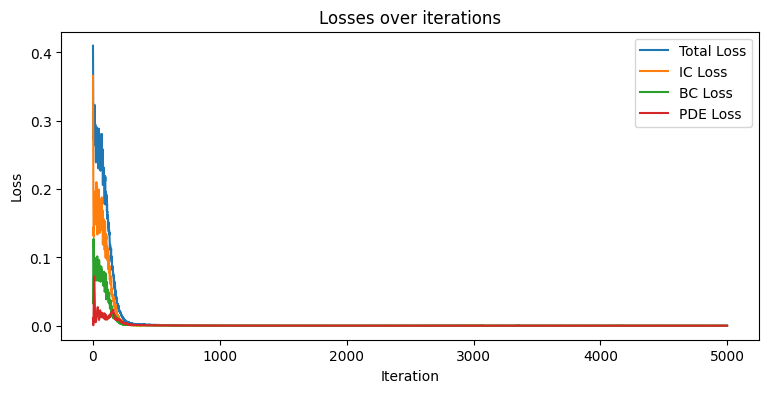

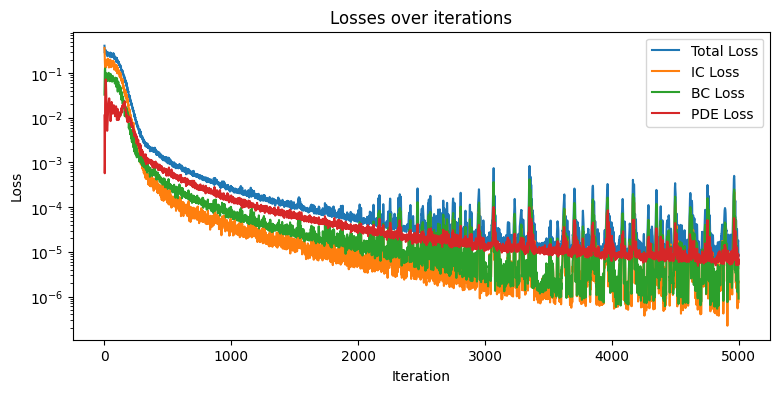

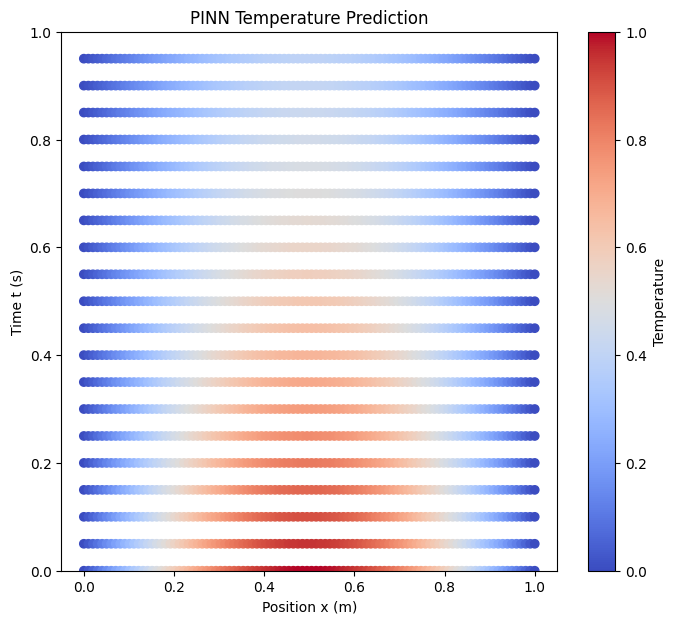

In [ ]:
alpha = 0.1 # thermal diffusivity [m^2/s]
L     = 1   # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100
system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_sinus_norm_alph01 = PINN()
losses = train_PINN(model_sinus_norm_alph01,
                    num_iterations = 5000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale= True)
plot_PINN_results(model_sinus_norm_alph01,system_params, num_time_steps=20)


#### Try playing with alpha values

iter 0 total_loss 0.712 ic_loss 0.7007 bc_loss 0.0109 pde_loss 0.0002
iter 1000 total_loss 0.003 ic_loss 0.0013 bc_loss 0.0006 pde_loss 0.0010
iter 2000 total_loss 0.000 ic_loss 0.0001 bc_loss 0.0001 pde_loss 0.0002
iter 3000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0000 pde_loss 0.0001
iter 4000 total_loss 0.000 ic_loss 0.0000 bc_loss 0.0001 pde_loss 0.0004


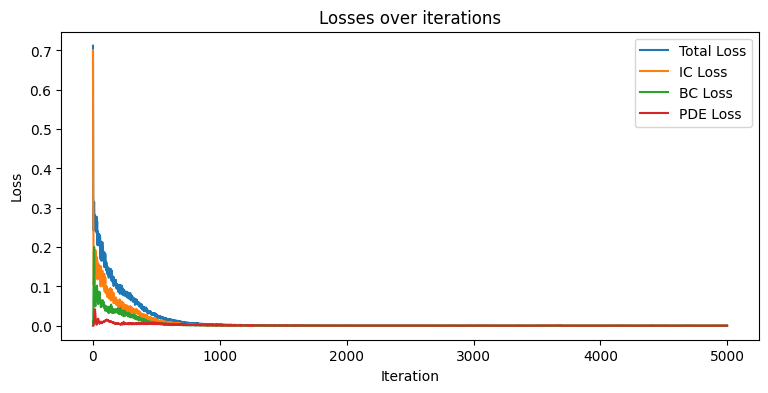

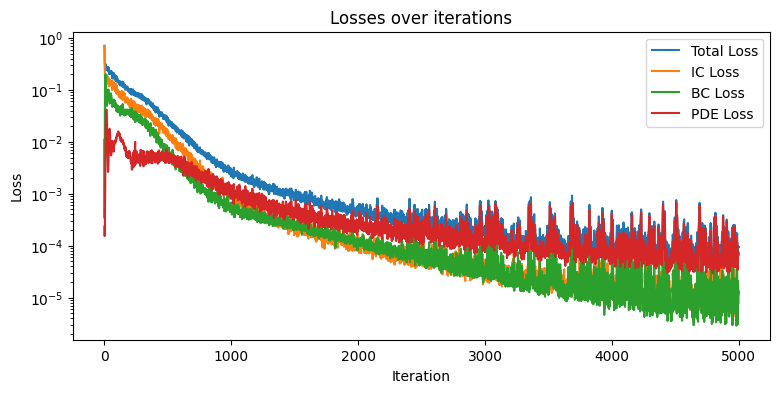

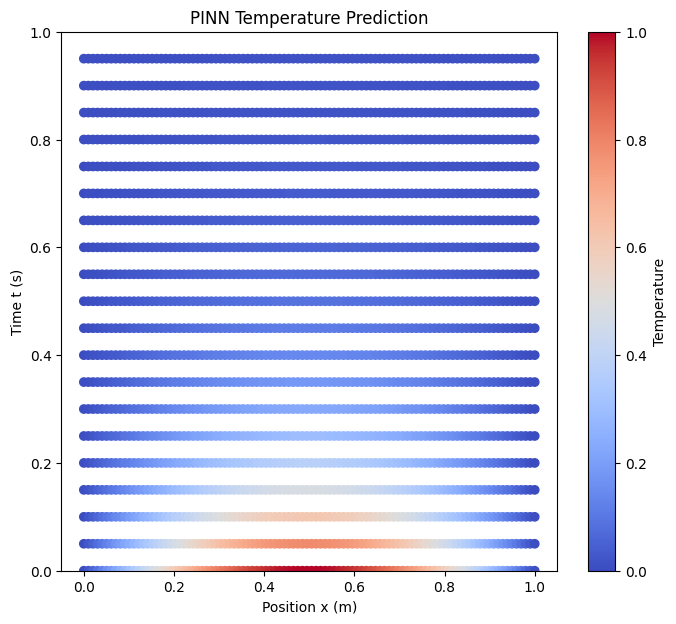

In [ ]:
alpha = 0.5 # thermal diffusivity [m^2/s]
L     = 1   # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100
system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_sinus_norm = PINN()
losses = train_PINN(model_sinus_norm,
                    num_iterations = 5000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale= True)
plot_PINN_results(model_sinus_norm,system_params, num_time_steps=20)

### Block IC , Norm (0-1) Values

iter 0 total_loss 0.575 ic_loss 0.5502 bc_loss 0.0206 pde_loss 0.0040
iter 1000 total_loss 0.210 ic_loss 0.1972 bc_loss 0.0088 pde_loss 0.0037
iter 2000 total_loss 0.119 ic_loss 0.1051 bc_loss 0.0044 pde_loss 0.0099
iter 3000 total_loss 0.081 ic_loss 0.0676 bc_loss 0.0016 pde_loss 0.0122
iter 4000 total_loss 0.054 ic_loss 0.0462 bc_loss 0.0018 pde_loss 0.0063
iter 5000 total_loss 0.051 ic_loss 0.0440 bc_loss 0.0017 pde_loss 0.0049
iter 6000 total_loss 0.046 ic_loss 0.0413 bc_loss 0.0009 pde_loss 0.0035
iter 7000 total_loss 0.044 ic_loss 0.0399 bc_loss 0.0010 pde_loss 0.0033
iter 8000 total_loss 0.038 ic_loss 0.0344 bc_loss 0.0012 pde_loss 0.0027
iter 9000 total_loss 0.045 ic_loss 0.0413 bc_loss 0.0015 pde_loss 0.0026


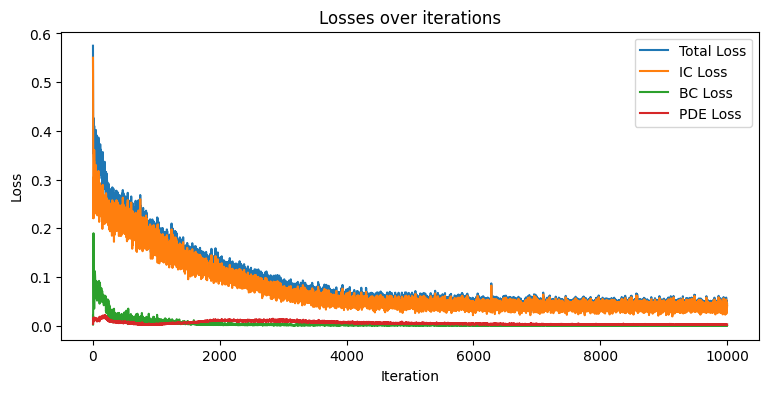

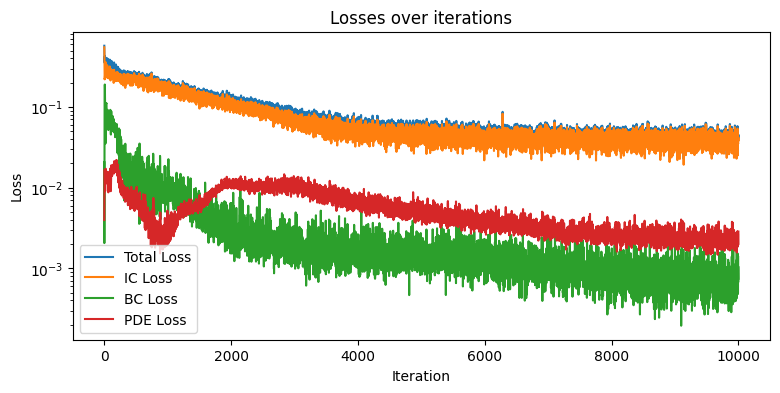

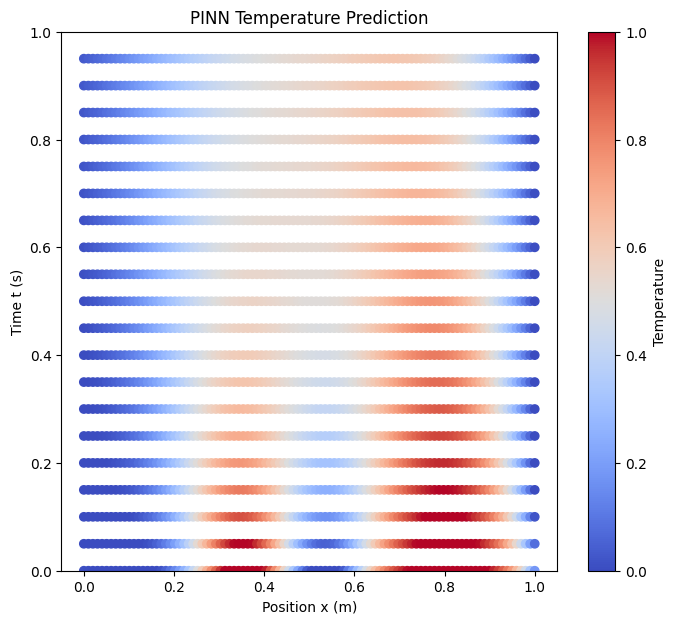

In [ ]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_norm_alpha002 = PINN()
losses = train_PINN(model_block_norm_alpha002,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model_block_norm_alpha002,system_params, num_time_steps=20)


#### No Grid Limitation
- Play with resolution

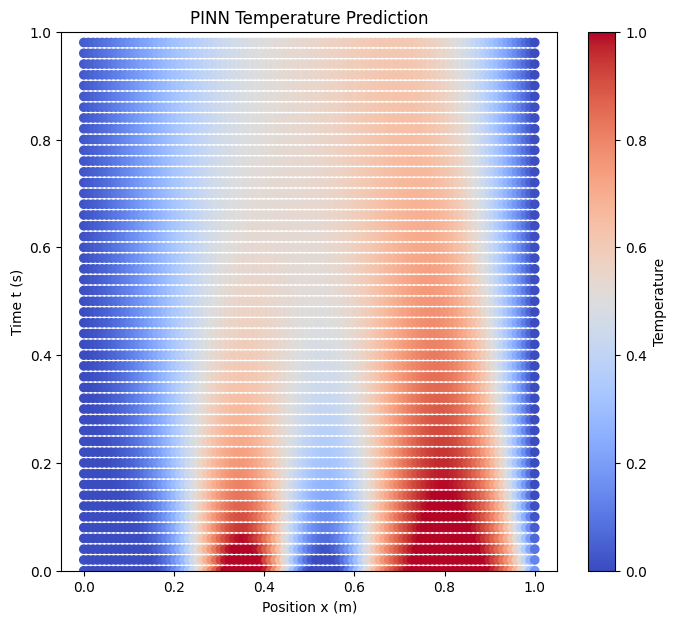

In [ ]:
plot_PINN_results(model_block_norm_alpha002,system_params, num_time_steps=50)

#### Try swithcing on/off the loss weights

*   W_pde = 0 , No physics learning



iter 0 total_loss 0.612 ic_loss 0.6050 bc_loss 0.0071 pde_loss 0.0000
iter 1000 total_loss 0.205 ic_loss 0.1950 bc_loss 0.0103 pde_loss 0.0000
iter 2000 total_loss 0.147 ic_loss 0.1374 bc_loss 0.0099 pde_loss 0.0000
iter 3000 total_loss 0.043 ic_loss 0.0386 bc_loss 0.0046 pde_loss 0.0000
iter 4000 total_loss 0.026 ic_loss 0.0245 bc_loss 0.0010 pde_loss 0.0000
iter 5000 total_loss 0.028 ic_loss 0.0273 bc_loss 0.0002 pde_loss 0.0000
iter 6000 total_loss 0.032 ic_loss 0.0310 bc_loss 0.0007 pde_loss 0.0000
iter 7000 total_loss 0.020 ic_loss 0.0193 bc_loss 0.0003 pde_loss 0.0000
iter 8000 total_loss 0.010 ic_loss 0.0092 bc_loss 0.0004 pde_loss 0.0000
iter 9000 total_loss 0.009 ic_loss 0.0084 bc_loss 0.0004 pde_loss 0.0000


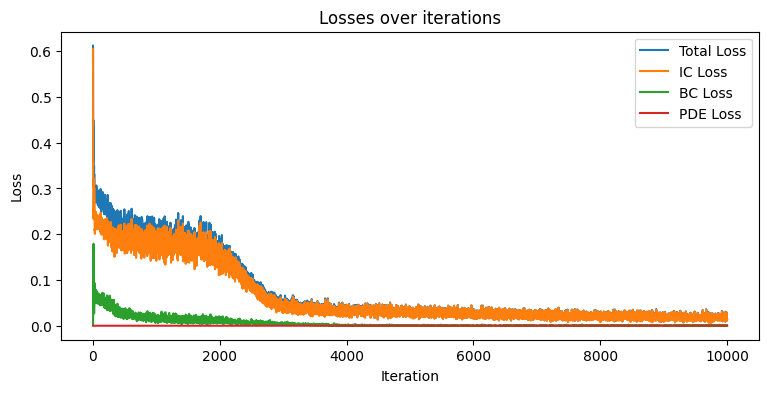

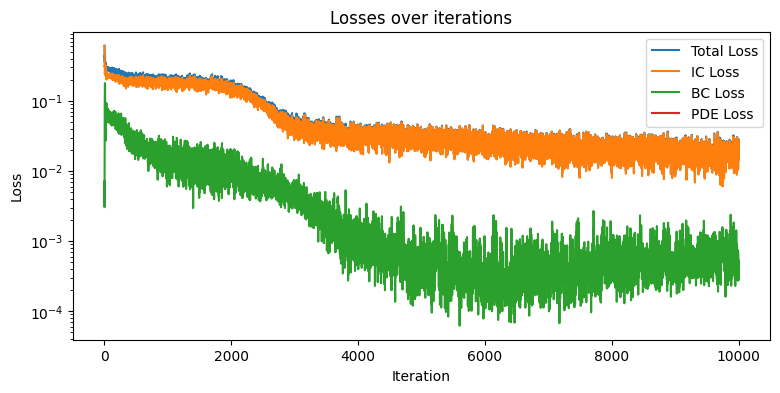

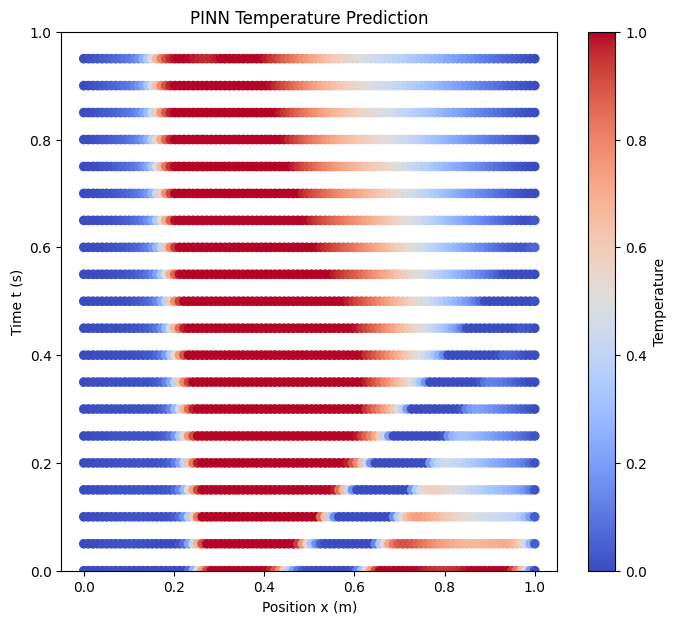

In [ ]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_norm = PINN()
losses = train_PINN(model_block_norm,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 0},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model_block_norm,system_params, num_time_steps=20)

iter 0 total_loss 0.738 ic_loss 0.7376 bc_loss 0.0000 pde_loss 0.0003
iter 1000 total_loss 0.180 ic_loss 0.1802 bc_loss 0.0000 pde_loss 0.0000
iter 2000 total_loss 0.185 ic_loss 0.1843 bc_loss 0.0000 pde_loss 0.0011
iter 3000 total_loss 0.102 ic_loss 0.0950 bc_loss 0.0000 pde_loss 0.0068
iter 4000 total_loss 0.084 ic_loss 0.0780 bc_loss 0.0000 pde_loss 0.0060
iter 5000 total_loss 0.043 ic_loss 0.0387 bc_loss 0.0000 pde_loss 0.0046
iter 6000 total_loss 0.037 ic_loss 0.0343 bc_loss 0.0000 pde_loss 0.0030
iter 7000 total_loss 0.042 ic_loss 0.0398 bc_loss 0.0000 pde_loss 0.0020
iter 8000 total_loss 0.045 ic_loss 0.0434 bc_loss 0.0000 pde_loss 0.0014
iter 9000 total_loss 0.043 ic_loss 0.0410 bc_loss 0.0000 pde_loss 0.0015


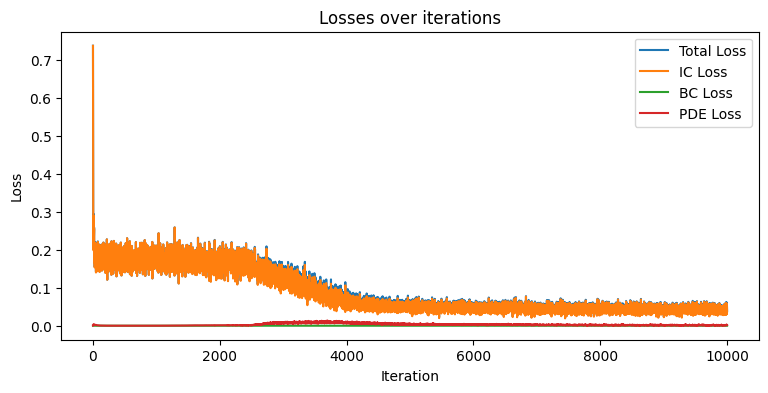

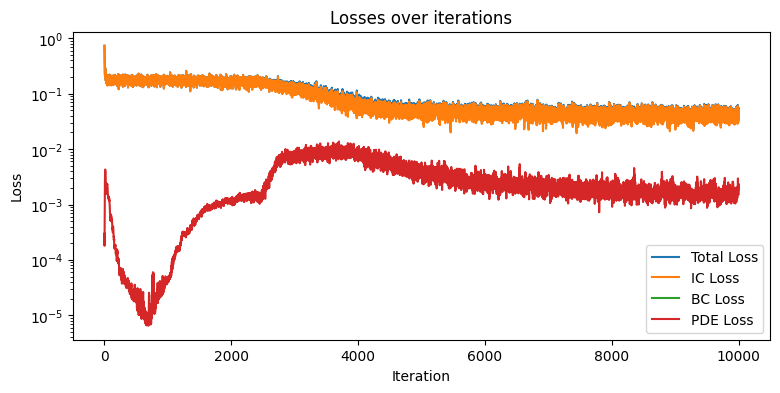

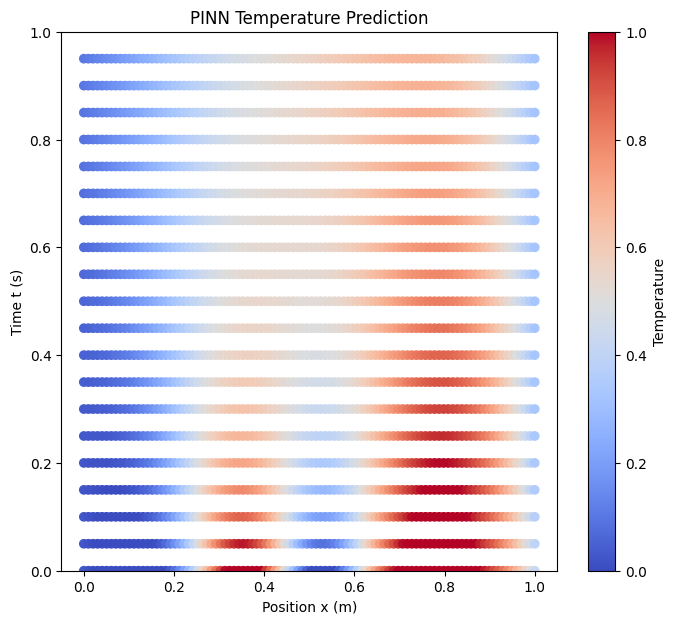

In [ ]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 1       # domain length [m]
T_max = 1   # max time [s]
U_max = 1   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_norm = PINN()
losses = train_PINN(model_block_norm,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 0, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model_block_norm,system_params, num_time_steps=20)

### **Normalization** - Lossc Weights Balancing

#### Sinus IC , "Real" Values

iter 0 total_loss 1252.883 ic_loss 1252.8212 bc_loss 0.0612 pde_loss 0.0002
iter 1000 total_loss 44.247 ic_loss 38.0591 bc_loss 0.1822 pde_loss 6.0061
iter 2000 total_loss 1.221 ic_loss 0.6389 bc_loss 0.1340 pde_loss 0.4477
iter 3000 total_loss 0.223 ic_loss 0.0643 bc_loss 0.0132 pde_loss 0.1458
iter 4000 total_loss 0.109 ic_loss 0.0297 bc_loss 0.0062 pde_loss 0.0735
iter 5000 total_loss 0.053 ic_loss 0.0158 bc_loss 0.0037 pde_loss 0.0331
iter 6000 total_loss 0.030 ic_loss 0.0036 bc_loss 0.0028 pde_loss 0.0232
iter 7000 total_loss 0.023 ic_loss 0.0028 bc_loss 0.0024 pde_loss 0.0181
iter 8000 total_loss 0.081 ic_loss 0.0011 bc_loss 0.0646 pde_loss 0.0151
iter 9000 total_loss 0.016 ic_loss 0.0009 bc_loss 0.0034 pde_loss 0.0117


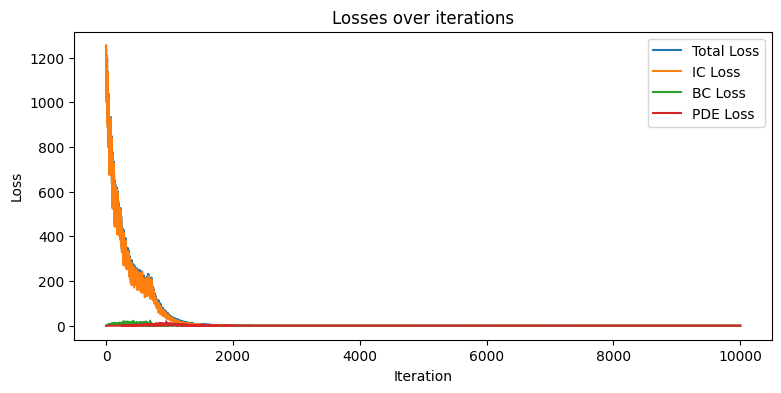

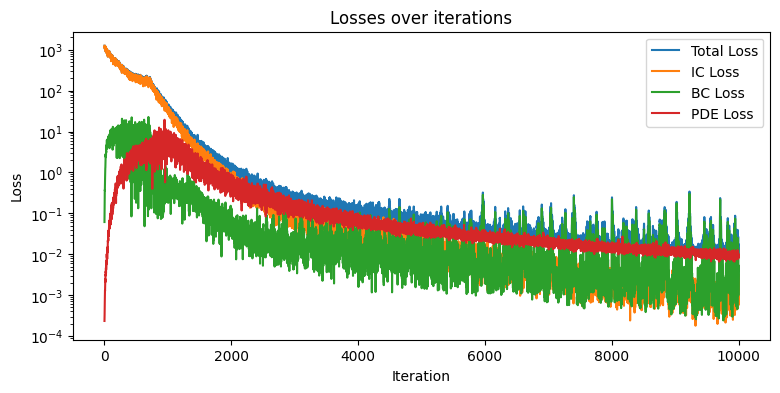

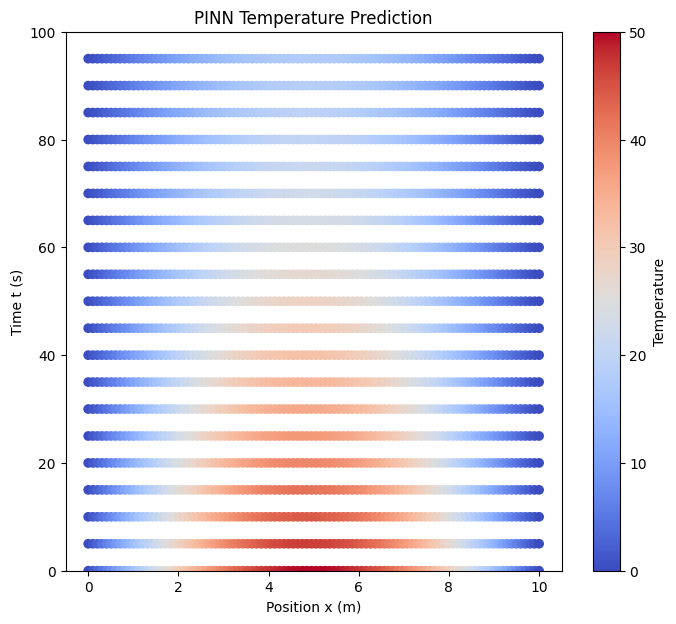

In [ ]:
alpha = 0.1      # original thermal diffusivity [m^2/s]
L     = 10       # domain length [m]
T_max = 100   # max time [s]
U_max = 50  # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model,system_params, num_time_steps=20)

Try swithcing balancing the loss weights

iter 0 total_loss 1.267 ic_loss 1.1043 bc_loss 0.1551 pde_loss 0.0076
iter 1000 total_loss 0.411 ic_loss 0.3398 bc_loss 0.0178 pde_loss 0.0536
iter 2000 total_loss 0.145 ic_loss 0.1118 bc_loss 0.0112 pde_loss 0.0222
iter 3000 total_loss 0.065 ic_loss 0.0504 bc_loss 0.0013 pde_loss 0.0132
iter 4000 total_loss 0.044 ic_loss 0.0276 bc_loss 0.0027 pde_loss 0.0140
iter 5000 total_loss 0.038 ic_loss 0.0191 bc_loss 0.0109 pde_loss 0.0077
iter 6000 total_loss 0.062 ic_loss 0.0102 bc_loss 0.0443 pde_loss 0.0077
iter 7000 total_loss 0.106 ic_loss 0.0073 bc_loss 0.0932 pde_loss 0.0055
iter 8000 total_loss 0.012 ic_loss 0.0053 bc_loss 0.0013 pde_loss 0.0052
iter 9000 total_loss 0.008 ic_loss 0.0037 bc_loss 0.0006 pde_loss 0.0035


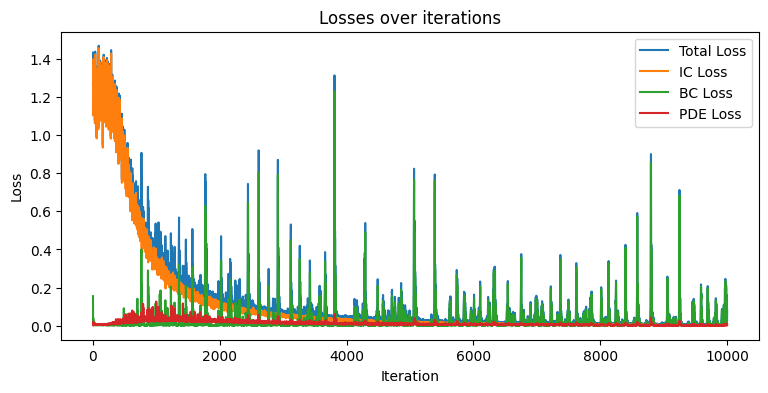

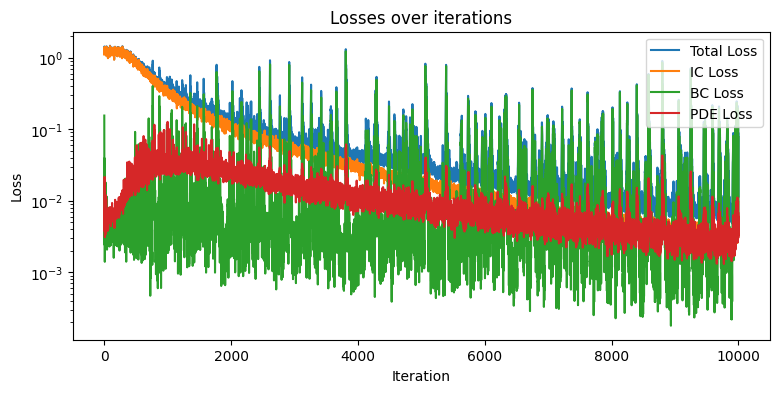

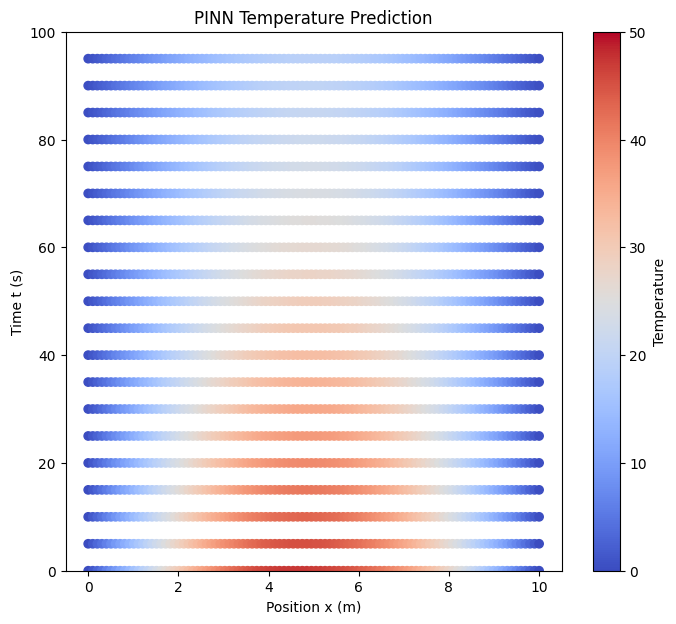

In [ ]:
alpha = 0.1      # original thermal diffusivity [m^2/s]
L     = 10       # domain length [m]
T_max = 100   # max time [s]
U_max = 50  # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model = PINN()
losses = train_PINN(model,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_sin,
                    loss_weights= {'ic': 0.001, 'bc': 1, 'pde': 100},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model,system_params, num_time_steps=20)

#### Block IC , "Real" Values

iter 0 total_loss 1428.664 ic_loss 1428.4803 bc_loss 0.1831 pde_loss 0.0004
iter 1000 total_loss 384.508 ic_loss 375.6623 bc_loss 6.8055 pde_loss 2.0406
iter 2000 total_loss 279.534 ic_loss 268.6350 bc_loss 5.2297 pde_loss 5.6692
iter 3000 total_loss 173.762 ic_loss 157.1290 bc_loss 0.3903 pde_loss 16.2430
iter 4000 total_loss 136.476 ic_loss 129.9288 bc_loss 0.1958 pde_loss 6.3516
iter 5000 total_loss 114.594 ic_loss 108.6122 bc_loss 3.8327 pde_loss 2.1490
iter 6000 total_loss 144.509 ic_loss 106.4446 bc_loss 35.3247 pde_loss 2.7401
iter 7000 total_loss 161.255 ic_loss 149.7710 bc_loss 5.1073 pde_loss 6.3765
iter 8000 total_loss 167.870 ic_loss 148.7690 bc_loss 0.0562 pde_loss 19.0444
iter 9000 total_loss 67.785 ic_loss 64.4654 bc_loss 0.0490 pde_loss 3.2709


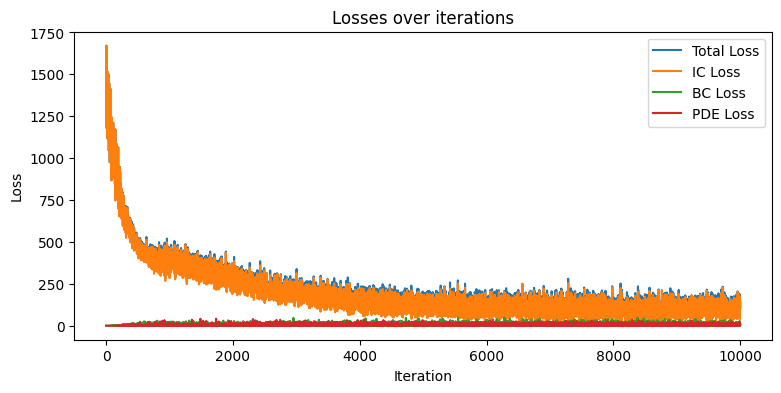

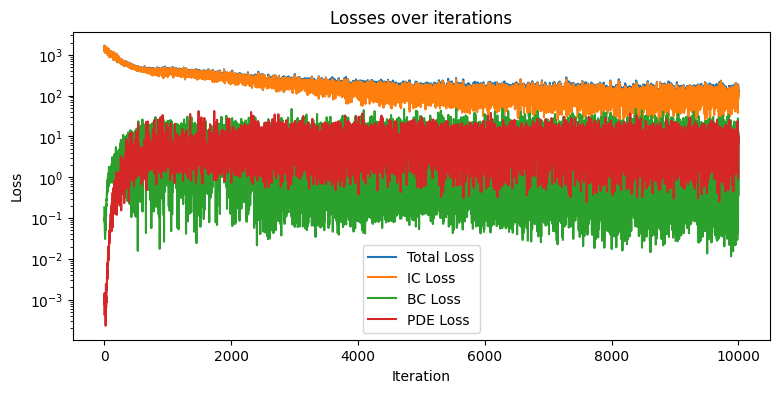

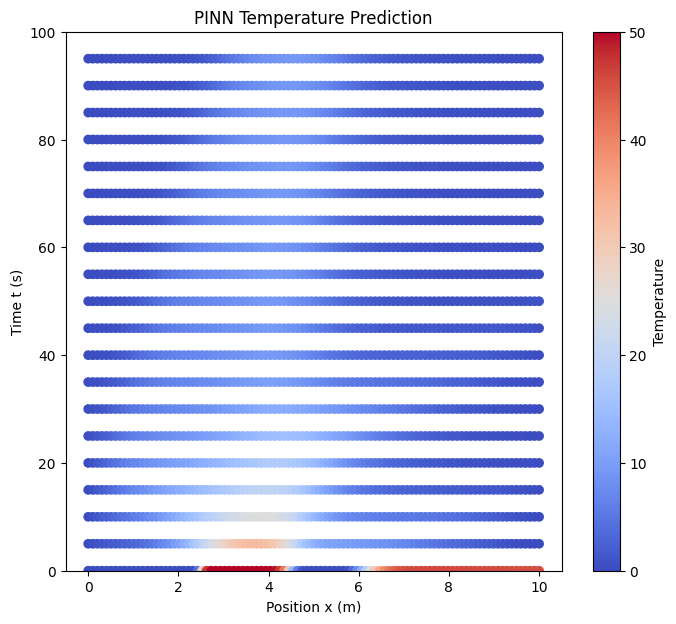

In [ ]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 10       # domain length [m]
T_max = 100   # max time [s]
U_max = 50   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_real = PINN()
losses = train_PINN(model_block_norm,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model_block_norm,system_params, num_time_steps=20)

iter 0 total_loss 1230.032 ic_loss 39.5418 bc_loss 10.5339 pde_loss 1179.9562
iter 1000 total_loss 97.194 ic_loss 45.7079 bc_loss 6.8025 pde_loss 44.6839
iter 2000 total_loss 51.170 ic_loss 29.3634 bc_loss 6.1345 pde_loss 15.6719
iter 3000 total_loss 79.227 ic_loss 57.6383 bc_loss 6.6487 pde_loss 14.9398
iter 4000 total_loss 41.848 ic_loss 21.3791 bc_loss 4.3627 pde_loss 16.1059
iter 5000 total_loss 55.161 ic_loss 39.3204 bc_loss 3.0595 pde_loss 12.7808
iter 6000 total_loss 80.640 ic_loss 45.5702 bc_loss 3.3698 pde_loss 31.7003
iter 7000 total_loss 40.239 ic_loss 24.1699 bc_loss 2.4514 pde_loss 13.6177
iter 8000 total_loss 63.886 ic_loss 49.2097 bc_loss 5.8299 pde_loss 8.8460
iter 9000 total_loss 65.662 ic_loss 50.8646 bc_loss 1.1978 pde_loss 13.5994


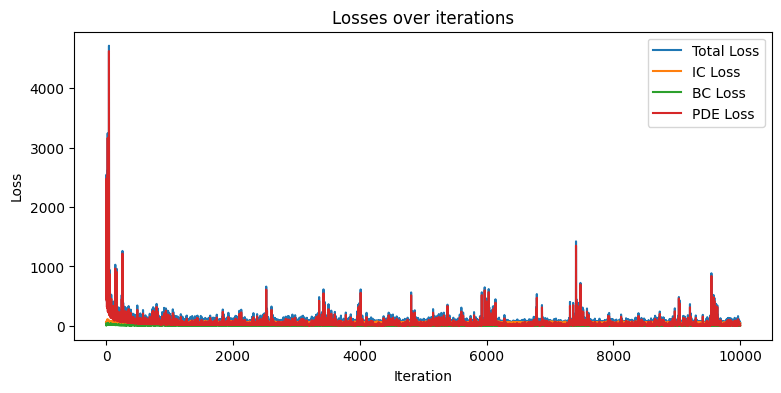

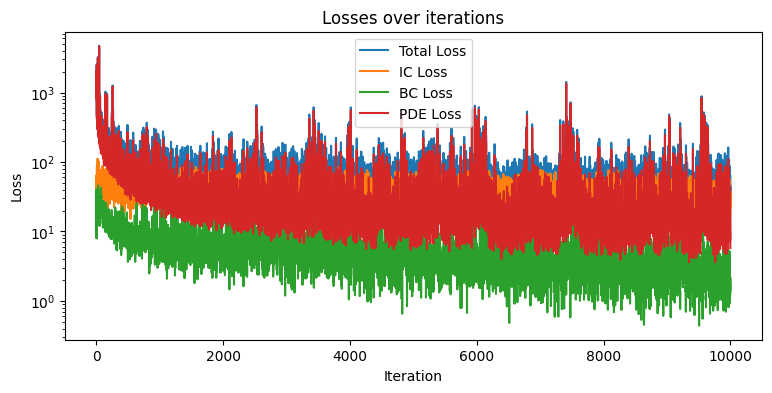

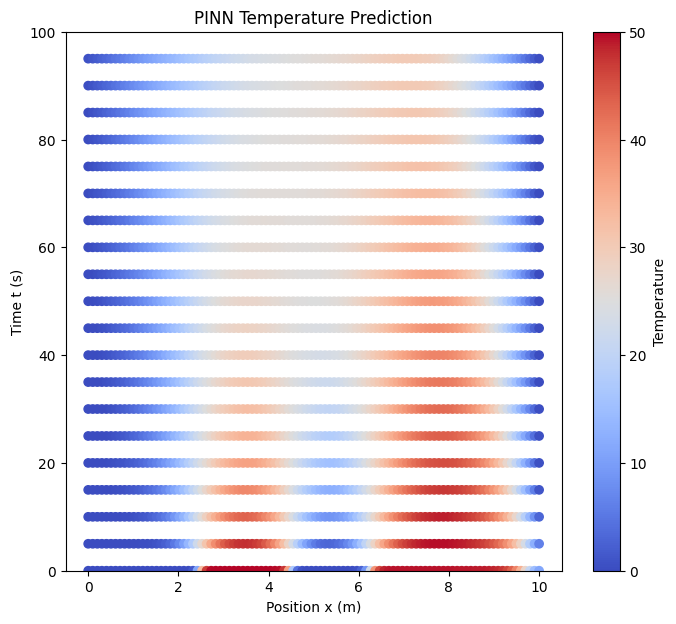

In [ ]:
alpha = 0.02       # original thermal diffusivity [m^2/s]
L     = 10       # domain length [m]
T_max = 100   # max time [s]
U_max = 50   # max temperature [°C]
num_domain_points = 1000
num_boundary_points = 100

system_params = {'alpha': alpha,'L': L, 'T_max': T_max, 'U_max': U_max}

model_block_real = PINN()
losses = train_PINN(model_block_norm,
                    num_iterations = 10000,
                    system_params = system_params,
                    num_domain_points = 1000,
                    num_boundary_points = 100,
                    initial_condition=i_c_block,
                    loss_weights= {'ic': 1, 'bc': 1, 'pde': 1000},
                    )

plot_losses(losses)
plot_losses(losses, log_scale=True)
plot_PINN_results(model_block_norm,system_params, num_time_steps=20)

## Simulate "measurments" data set
### Sample the model predictions point and add noise

### Block IC

#### Sample model predictions

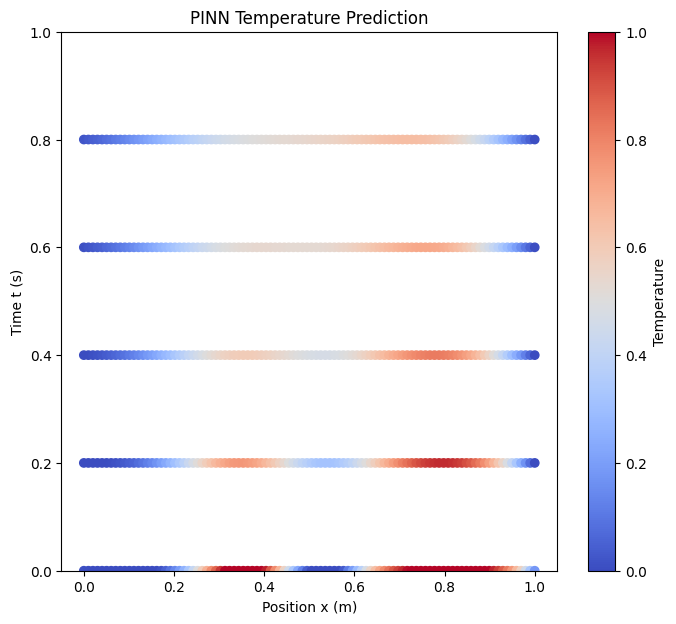

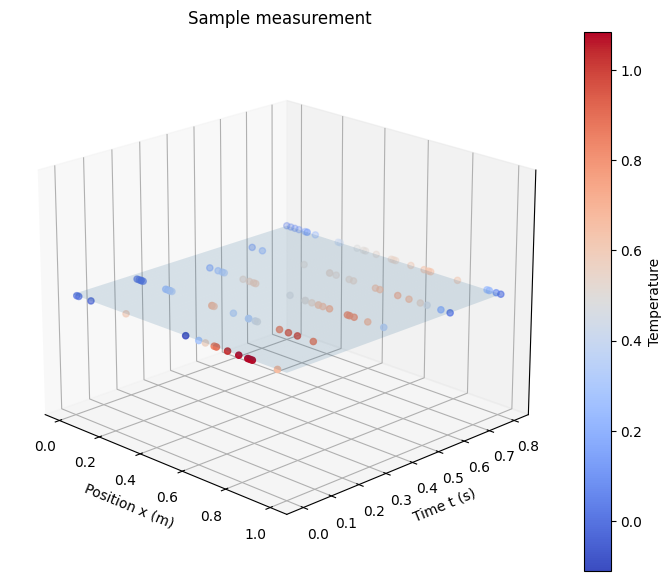

x    t         u
3   0.606061  0.0  0.289226
8   0.090909  0.0 -0.048622
29  0.262626  0.0  0.592707
26  0.686869  0.0  0.889561
27  0.545455  0.0 -0.111203
..       ...  ...       ...
71  0.525253  0.8  0.551541
95  0.515152  0.8  0.547928
94  0.686869  0.8  0.639524
93  0.595960  0.8  0.587606
91  0.808081  0.8  0.596080

[100 rows x 3 columns]

In [ ]:
df_sample_results_block = plot_PINN_results(model_block_norm_alpha002,system_params,
                                            num_time_steps=5,
                                            sample_results=100)

x,t,u= df_sample_results_block['x'], df_sample_results_block['t'], df_sample_results_block['u']
plot_results_2D_tilted(x,t,u)
df_sample_results_block.sort_values(by='t')

#### Add random noise

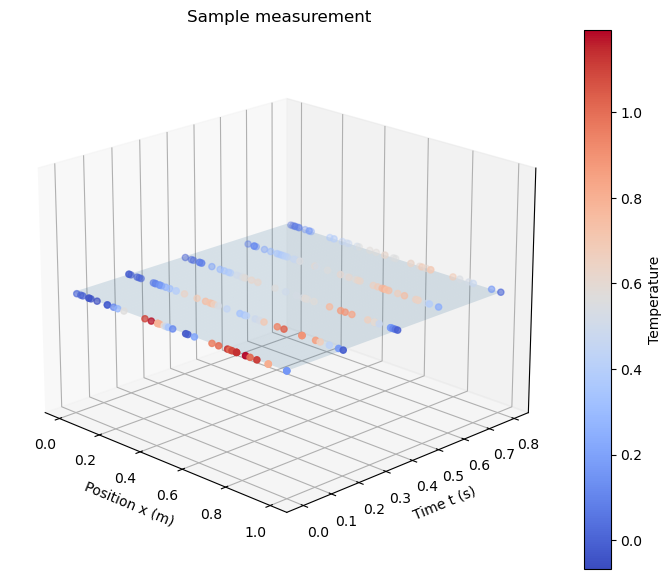

In [ ]:
noise_level = 0.1
df_noisy_block = df_sample_results_block.copy()
df_noisy_block['u'] = df_noisy_block['u'] + np.random.uniform(-noise_level, noise_level, len(df_noisy_block)) * df_noisy_block['u']
x,t,u= df_noisy_block['x'], df_noisy_block['t'], df_noisy_block['u']
plot_results_2D_tilted(x,t,u)

##### Save to csv

In [ ]:
### Save the df_sample_results_block to a csv file
file_name = 'sample_data_blockIC_200_alpha_0.02.csv'
df_noisy_block.to_csv('Data_sets/'+file_name, index=False)


### Sinus IC

#### Sample model predictions

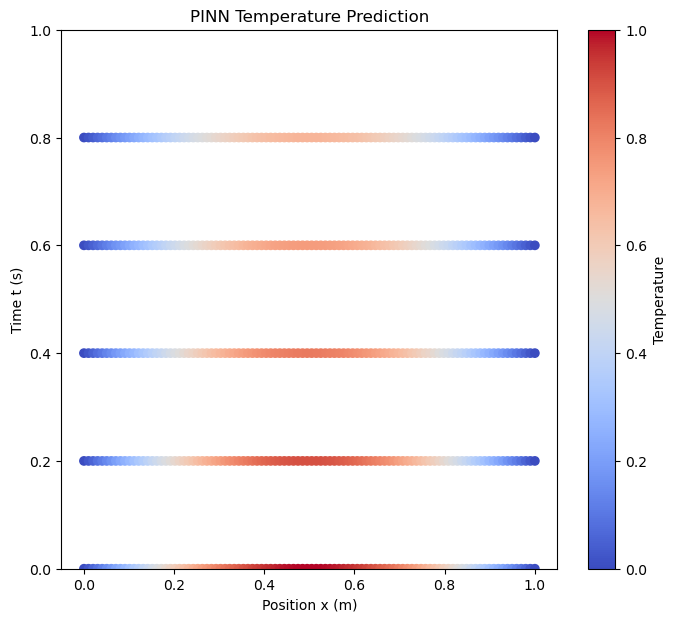

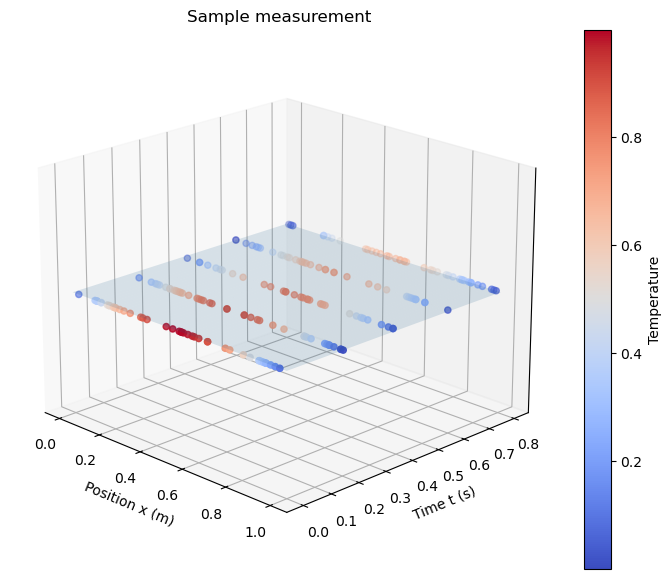

In [ ]:
df_sample_results_sinus = plot_PINN_results(model_sinus_norm,system_params,
                                            num_time_steps=5,
                                            sample_results=200)

x, t, u = df_sample_results_sinus['x'], df_sample_results_sinus['t'], df_sample_results_sinus['u']
plot_results_2D_tilted(x,t,u)

#### Create Noise

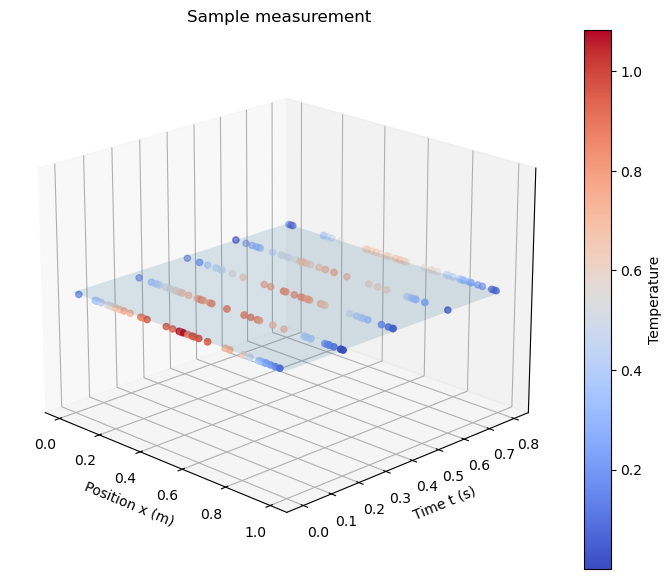

original_u   noisy_u
0      0.712481  0.777678
1      0.676626  0.621589
2      0.114740  0.115779
3      0.232386  0.251978
4      0.655547  0.665789
..          ...       ...
195    0.666455  0.696925
196    0.199481  0.184939
197    0.512955  0.562911
198    0.667263  0.631139
199    0.064075  0.064949

[200 rows x 2 columns]

In [ ]:
noise_level = 0.1
df_noisy_sinus = df_sample_results_sinus.copy()
# create a random noise between -noise_level and noise_level
df_noisy_sinus['u'] = df_noisy_sinus['u'] + np.random.uniform(-noise_level, noise_level, len(df_noisy_sinus)) * df_noisy_sinus['u']

x,t,u= df_noisy_sinus['x'], df_noisy_sinus['t'], df_noisy_sinus['u']
plot_results_2D_tilted(x,t,u)

# create new compare_df with 2 columns, original u and noisy u
compare_df = pd.DataFrame({'original_u': df_sample_results_sinus['u'], 'noisy_u': df_noisy_sinus['u']})
compare_df

#### Save to csv

In [ ]:
# save df_noisy_sinus to a csv file
file_name = 'sample_results_sinus_200_alpha_0.05.csv'
df_noisy_sinus.to_csv('Data_sets/'+file_name, index=False)

In [ ]:
# Installs required to run this notebook
!pip install torch matplotlib numpy pandas